# Pump it Up: Data Mining the Water Table

## Introduction

Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

## Objectives
- create a classifier
- clasify faulty pumps

## Tabel of contents

1. Problem Description
1. Import Datra
2. Data Analysis
    - 2.1 X_train & y_train info

## 1. Import Data
- import all the necessary classes, functions, and packages

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import pickle
import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

/Users/Filip/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Load and split preprocessed data into X and y
with open('X_processed.pickle', 'rb') as f:
    X = pickle.load(f)
    
df_labels = pd.read_csv('Water_Table_Training_set_labels.csv')
y = df_labels.drop('id', axis=1)
y.columns = ['target']

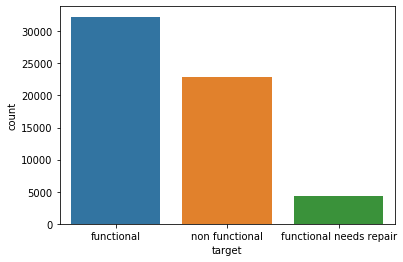

In [4]:
sns.countplot(y['target']);

In [5]:
# Create summary of Nan and unique values counts and data types
X_info = pd.DataFrame(X.isna().sum(), columns=['NaN count'])

unique_val = []
types_val = []
zero_val = []

for column in X.columns:
    unique = len(X[column].unique())
    types = str(X[column].dtype)
    zeros = len(X[X[column]==0])
    
    unique_val.append(unique)
    types_val.append(types)
    zero_val.append(zeros)

X_info['Zero values count'] = zero_val
X_info['Unique_val count'] = unique_val
X_info['Data type'] = types_val

X_info

,NaN count,Zero values count,Unique_val count,Data type
amount_tsh,0,41639,98,float64
date_recorded,0,0,356,object
funder,3635,0,1898,object
gps_height,0,20438,2428,int64
installer,3655,0,2146,object
longitude,0,0,57583,float64
latitude,0,0,57583,float64
wpt_name,0,0,37400,object
num_private,0,58643,65,int64
basin,0,0,9,object


## Label Encode String Class Values

In [6]:
y['target'].unique()

array(['functional', 'non functional', 'functional needs repair'],
      dtype=object)

In [7]:
# Convert y labels
y = y.replace({'target': {'functional' : 1, 
                                'non functional' : 0, 
                                'functional needs repair' : 2}})

In [8]:
y['target'] = y['target'].astype(int)

In [9]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   target  59400 non-null  int64
dtypes: int64(1)
memory usage: 464.2 KB


## Multiclass Imbalance

In [10]:
from sklearn.utils import class_weight

classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y['target']
)

# xgb_classifier.fit(X, y, sample_weight=classes_weights)

In [11]:
np.unique(classes_weights)

array([0.6137822 , 0.86750789, 4.58651842])

## Target Encode Categorical Data

In [12]:
# import category_encoders as ce
# ce_poly = ce.PolynomialEncoder(cols = ['basin'])

# # ce_target = ce.TargetEncoder(cols = ['basin'])
# ce_poly.fit_transform(X, y).head().T

In [13]:
def target_encode_multiclass(X,y): #X,y are pandas df and series
    y=y.astype(str)   #convert to string to onehot encode
    enc=ce.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)
    class_names=y_onehot.columns  #names of onehot encoded columns
    X_obj=X.select_dtypes('object') #separate categorical columns
    X=X.select_dtypes(exclude='object') 
  
    for class_ in class_names:
      
        enc=ce.TargetEncoder()
        enc.fit(X_obj,y_onehot[class_]) #convert all categorical 
        temp=enc.transform(X_obj)       #columns for class_
        temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
        X=pd.concat([X,X_obj,temp],axis=1)    #add to original dataset
      
    return X

In [14]:
def target_encode_dict(X,y): #X,y are pandas df and series
    y=y.astype(str)   #convert to string to onehot encode
    enc=ce.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)
    class_names=y_onehot.columns  #names of onehot encoded columns
    X_obj=X.select_dtypes('object') #separate categorical columns
    X=X.select_dtypes(exclude='object') 
    X_1 = X_obj.copy()
    cat_target_dict = {}
    
    for class_ in class_names:
      
        enc=ce.TargetEncoder()
        enc.fit(X_obj,y_onehot[class_]) #convert all categorical 
        temp=enc.transform(X_obj)       #columns for class_
        temp.columns=[str(x)+'_'+str(class_) for x in temp.columns]
        X_1=pd.concat([X_1,temp],axis=1)    #add to original dataset
        X=pd.concat([X,temp],axis=1)
        
    for column in X_obj.columns:
        column_list=[column]
        
        for target in class_names:
            column_list.append(str(column)+'_'+str(target))
        
        cat_targets_df = X_1[column_list]
        cat_targets_df.drop_duplicates(subset = [column], inplace=True)
        cat_targets_df.set_index(column, inplace=True)
        dict_=cat_targets_df.to_dict()
        cat_target_dict={**cat_target_dict, **dict_}
      
    return X, cat_target_dict

In [15]:
#Add target encoding columns do dataframe
def add_train_targets(X_test, y_train, target_encode_dict):
    y=y_train.astype(str)   #convert to string to onehot encode
    enc=ce.OneHotEncoder().fit(y)
    y_onehot=enc.transform(y)
    class_names=y_onehot.columns  #names of onehot encoded columns
    X_obj=X_test.select_dtypes('object') #separate categorical columns
    X=X_test.select_dtypes(exclude='object') 
    temp = pd.DataFrame()  
    
    for column in X_obj.columns:
        for class_ in class_names:
            temp[str(column)+'_'+str(class_)]=X_obj[column]
            temp[str(column)+'_'+str(class_)]=temp[str(column)+'_'+str(class_)].map(target_encode_dict[str(column)+'_'+str(class_)])
    
    X_test=pd.concat([X, temp],axis=1)
    X_test.fillna(0.33, inplace=True)
    
    return X_test

In [16]:
def group_low_frequency_val(X, threshold=15, name='other'):
    lowFreqVal_dict = {}
    X_obj=X.select_dtypes('object')

    for column in X_obj.columns:
        lowFreqVal = X_obj[column].value_counts().to_frame()
        lowFreqVal = lowFreqVal[lowFreqVal[column] < threshold]
        lowFreqVal[column] = name
        lowFreqVal = lowFreqVal.to_dict()
        lowFreqVal_dict={**lowFreqVal_dict, **lowFreqVal}
        
    return lowFreqVal_dict

In [17]:
def update_X_low_freq_val(X, dict_):
    X_obj=X.select_dtypes('object')
    
    for column in X_obj.columns:
        X[column]=X[column].replace(dict_[column])
    
    return X

In [18]:
X[['region_code', 'district_code']] = X[['region_code', 'district_code']].astype(str)
X.drop(columns=['date_recorded'], inplace=True)

## Support for Missing Data

In [19]:
# Replace all NaN elements with 0s.
X.fillna(0, inplace=True)

In [20]:
X.select_dtypes('object').columns

Index(['funder', 'installer', 'wpt_name', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

## Train the XGBoost Model

In [25]:
def data_processing(X, y, threshold=10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    #Check for number of unique keys for column after applying threshold
    low_frequency_val_train = group_low_frequency_val(X_train, threshold)
    #Group low frequency values to 'other' category for each column
    X_train = update_X_low_freq_val(X_train, low_frequency_val_train)
    
    X_train, target_dict = target_encode_dict(X_train, y_train)
    X_test = update_X_low_freq_val(X_test, low_frequency_val_train)
    X_test = add_train_targets(X_test, y, target_dict)
    X_test.fillna(0, inplace=True)
    X_train.sort_index(axis=1, inplace=True)
    X_test.sort_index(axis=1,inplace=True)
    
    # Scale data
    scaler = StandardScaler()
    # Transform the training and test sets
    scaled_data_train = scaler.fit_transform(X_train) #fit calculates mean and variance
    scaled_data_test = scaler.transform(X_test)
    # Convert into a DataFrame
    scaled_X_train = pd.DataFrame(scaled_data_train, columns=X_train.columns)
    scaled_X_train
    
    # This will transform the selected columns and merge to the original data frame
    scaled_X_test = pd.DataFrame(scaled_data_test, columns=X_test.columns)
    scaled_X_test
    
    return scaled_X_train, scaled_X_test, y_train, y_test

In [27]:
threshold_list = [3,6,10,15,20,25,30,40]

for threshold in threshold_list:

    scaled_X_train, scaled_X_test, y_train, y_test = data_processing(X, y, threshold)
    clf = xgb.XGBClassifier(learning_rate = 0.6, 
                            min_child_weight = 1,
                            gamma = 4, 
                            n_estimators = 250,
                            subsample = 0.9,
                            objective = 'multi:softmax',
                            reg_lambda = 1)

    clf.fit(scaled_X_train, y_train, sample_weight=classes_weights)
    training_preds = clf.predict(scaled_X_train)
    val_preds = clf.predict(scaled_X_test)
    training_accuracy = accuracy_score(y_train, training_preds)
    val_accuracy = accuracy_score(y_test, val_preds)

    print('threshold: ', threshold)
    print('-----------------------')
    print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
    print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
    print('')

threshold:  3
-----------------------
Training Accuracy: 84.97%
Validation accuracy: 72.01%

threshold:  6
-----------------------
Training Accuracy: 82.84%
Validation accuracy: 71.99%

threshold:  10
-----------------------
Training Accuracy: 82.11%
Validation accuracy: 75.63%

threshold:  15
-----------------------
Training Accuracy: 81.52%
Validation accuracy: 74.03%

threshold:  20
-----------------------
Training Accuracy: 81.66%
Validation accuracy: 74.26%

threshold:  25
-----------------------
Training Accuracy: 81.42%
Validation accuracy: 74.26%

threshold:  30
-----------------------
Training Accuracy: 81.37%
Validation accuracy: 72.88%

threshold:  40
-----------------------
Training Accuracy: 81.19%
Validation accuracy: 75.66%



In [28]:
threshold_list = [50,70, 100]

for threshold in threshold_list:

    scaled_X_train, scaled_X_test, y_train, y_test = data_processing(X, y, threshold)
    clf = xgb.XGBClassifier(learning_rate = 0.6, 
                            min_child_weight = 1,
                            gamma = 4, 
                            n_estimators = 250,
                            subsample = 0.9,
                            objective = 'multi:softmax',
                            reg_lambda = 1)

    clf.fit(scaled_X_train, y_train, sample_weight=classes_weights)
    training_preds = clf.predict(scaled_X_train)
    val_preds = clf.predict(scaled_X_test)
    training_accuracy = accuracy_score(y_train, training_preds)
    val_accuracy = accuracy_score(y_test, val_preds)

    print('threshold: ', threshold)
    print('-----------------------')
    print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
    print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
    print('')

threshold:  50
-----------------------
Training Accuracy: 81.08%
Validation accuracy: 75.48%

threshold:  70
-----------------------
Training Accuracy: 81.06%
Validation accuracy: 75.74%

threshold:  100
-----------------------
Training Accuracy: 81.23%
Validation accuracy: 76.17%



In [29]:
threshold_list = [150,200,300]

for threshold in threshold_list:

    scaled_X_train, scaled_X_test, y_train, y_test = data_processing(X, y, threshold)
    clf = xgb.XGBClassifier(learning_rate = 0.6, 
                            min_child_weight = 1,
                            gamma = 4, 
                            n_estimators = 250,
                            subsample = 0.9,
                            objective = 'multi:softmax',
                            reg_lambda = 1)

    clf.fit(scaled_X_train, y_train, sample_weight=classes_weights)
    training_preds = clf.predict(scaled_X_train)
    val_preds = clf.predict(scaled_X_test)
    training_accuracy = accuracy_score(y_train, training_preds)
    val_accuracy = accuracy_score(y_test, val_preds)

    print('threshold: ', threshold)
    print('-----------------------')
    print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
    print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
    print('')

threshold:  150
-----------------------
Training Accuracy: 80.91%
Validation accuracy: 77.14%

threshold:  200
-----------------------
Training Accuracy: 81.14%
Validation accuracy: 77.52%

threshold:  300
-----------------------
Training Accuracy: 81.07%
Validation accuracy: 78.16%



In [30]:
threshold_list = [350,400,500]

for threshold in threshold_list:

    scaled_X_train, scaled_X_test, y_train, y_test = data_processing(X, y, threshold)
    clf = xgb.XGBClassifier(learning_rate = 0.6, 
                            min_child_weight = 1,
                            gamma = 4, 
                            n_estimators = 250,
                            subsample = 0.9,
                            objective = 'multi:softmax',
                            reg_lambda = 1)

    clf.fit(scaled_X_train, y_train, sample_weight=classes_weights)
    training_preds = clf.predict(scaled_X_train)
    val_preds = clf.predict(scaled_X_test)
    training_accuracy = accuracy_score(y_train, training_preds)
    val_accuracy = accuracy_score(y_test, val_preds)

    print('threshold: ', threshold)
    print('-----------------------')
    print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
    print("Validation accuracy: {:.4}%".format(val_accuracy * 100))
    print('')

threshold:  350
-----------------------
Training Accuracy: 80.88%
Validation accuracy: 78.3%

threshold:  400
-----------------------
Training Accuracy: 80.87%
Validation accuracy: 78.11%

threshold:  500
-----------------------
Training Accuracy: 80.77%
Validation accuracy: 78.0%



In [1010]:
#Check for number of unique keys for column after applying threshold
low_frequency_val_train = group_low_frequency_val(X_train, threshold=10)
print(len(low_frequency_val_train['funder'].keys()))

1278


In [ ]:
threshold_list = [3,6,10,15,20,25,30,40,50]

for threshold in threshold_list:
    data_processing(X, y, threshold=10)
    


In [1022]:
# threshold=10
clf = xgb.XGBClassifier(learning_rate = 0.6, 
                        min_child_weight = 1,
                        gamma = 4, 
                        n_estimators = 250,
                        subsample = 0.9,
                        objective = 'multi:softmax',
                        reg_lambda = 1)

clf.fit(scaled_X_train, y_train, sample_weight=classes_weights)
training_preds = clf.predict(scaled_X_train)
val_preds = clf.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

# Training Accuracy: 81.52%
# Validation accuracy: 76.69%

Training Accuracy: 82.11%
Validation accuracy: 75.63%


In [812]:
# threshold=15
clf = xgb.XGBClassifier(learning_rate = 0.6, 
                        min_child_weight = 1,
                        gamma = 4, 
                        n_estimators = 250,
                        subsample = 0.9,
                        objective = 'multi:softmax',
                        reg_lambda = 1)

clf.fit(scaled_X_train, y_train, sample_weight=classes_weights)
training_preds = clf.predict(scaled_X_train)
val_preds = clf.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

# Training Accuracy: 81.52%
# Validation accuracy: 76.69%

Training Accuracy: 81.52%
Validation accuracy: 76.69%


In [1008]:
#  threshold=30
clf = xgb.XGBClassifier(learning_rate = 0.6, 
                        min_child_weight = 1,
                        gamma = 4, 
                        n_estimators = 250,
                        subsample = 0.9,
                        objective = 'multi:softmax',
                        reg_lambda = 1)

clf.fit(scaled_X_train, y_train, sample_weight=classes_weights)
training_preds = clf.predict(scaled_X_train)
val_preds = clf.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

# Training Accuracy: 81.52%
# Validation accuracy: 74.03%

Training Accuracy: 81.37%
Validation accuracy: 72.88%


In [524]:
param_grid = {'learning_rate': [0.3, 0.4, 0.5, 0.6], 
            'min_child_weight': [1], 
            'n_estimators': [100, 150, 250],
            'reg_lambda': [1],
            'gamma': [4],
            'subsample': [0.8, 0.9, 1],
            'objective': ['multi:softmax']}

# scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

clf = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf, 
                        param_grid,  
                        cv=3, 
                        n_jobs=-1,
                        scoring='accuracy', 
                        return_train_score=True,
                        verbose=12)

grid_clf.fit(scaled_X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(scaled_X_train)
val_preds = grid_clf.predict(scaled_X_test)
training_accuracy = accuracy_score(y_train, training_preds)
val_accuracy = accuracy_score(y_test, val_preds)

print("")
print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  7

Grid Search found the following optimal parameters: 
gamma: 4
learning_rate: 0.6
min_child_weight: 1
n_estimators: 250
objective: 'multi:softmax'
reg_lambda: 1
subsample: 0.9

Training Accuracy: 86.62%
Validation accuracy: 71.12%


In [525]:
results = pd.DataFrame(grid_clf.cv_results_)
results.to_csv('grid_search_results.csv', index=False)

In [ ]:
# Shallow trees are expected to have poor performance because they capture few details of the problem 
# and are generally referred to as weak learners. Deeper trees generally capture too many details of the problem 
# and overfit the training dataset, limiting the ability to make good predictions on new data.

In [526]:
cm = confusion_matrix(y_test, val_preds)
print(cm)

[[4513 1085   80]
 [2088 5861  149]
 [ 389  497  188]]


In [528]:
results[results['rank_test_score']==1].T

,34
mean_fit_time,227.73
std_fit_time,0.30361
mean_score_time,0.46696
std_score_time,0.0226949
param_gamma,4
param_learning_rate,0.6
param_min_child_weight,1
param_n_estimators,250
param_objective,multi:softmax
param_reg_lambda,1


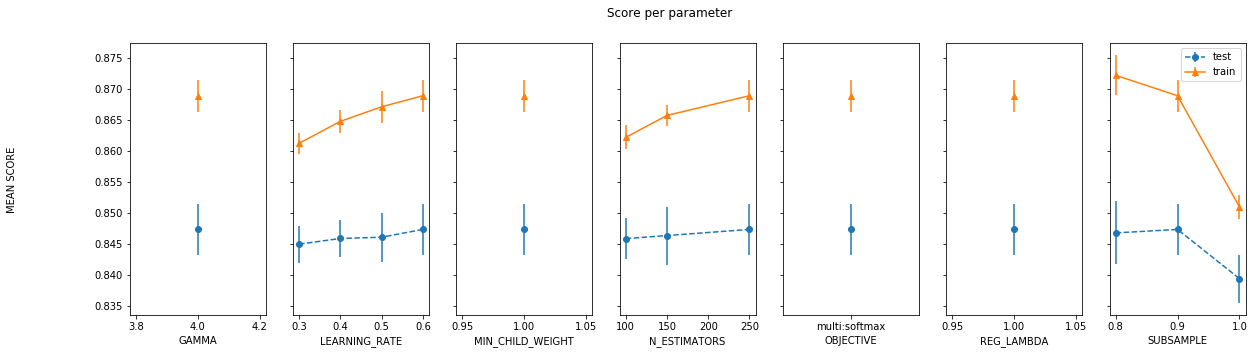

In [529]:
plot_search_results(grid_clf)

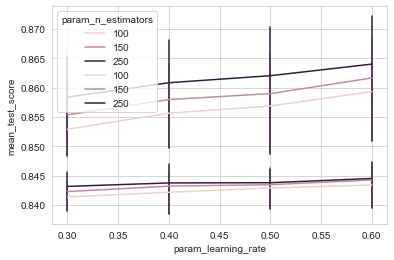

In [530]:
sns.set_style("whitegrid")
sns.lineplot(data=results, x="param_learning_rate", y="mean_test_score", hue='param_n_estimators', err_style="bars", ci=95
)
sns.lineplot(data=results, x="param_learning_rate", y="mean_train_score", hue='param_n_estimators', err_style="bars", ci=95
)

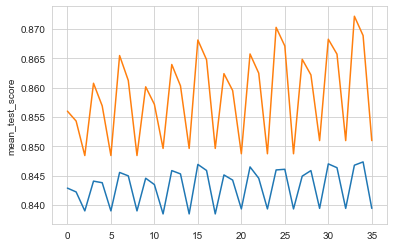

In [531]:
sns.lineplot(data=results, x=list(results.index), y="mean_test_score")
sns.lineplot(data=results, x=list(results.index), y="mean_train_score")

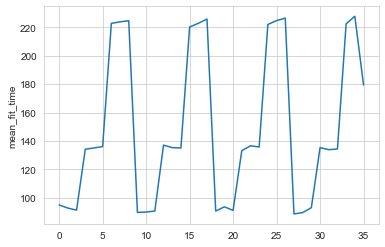

In [532]:
sns.lineplot(data=results, x=list(results.index), y="mean_fit_time")

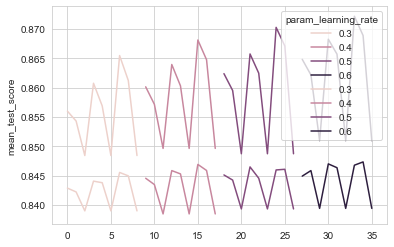

In [533]:
sns.lineplot(data=results, x=list(results.index), y="mean_test_score", hue='param_learning_rate')
sns.lineplot(data=results, x=list(results.index), y="mean_train_score", hue='param_learning_rate')

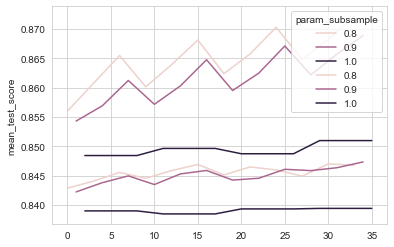

In [534]:
sns.lineplot(data=results, x=list(results.index), y="mean_test_score", hue='param_subsample')
sns.lineplot(data=results, x=list(results.index), y="mean_train_score", hue='param_subsample')

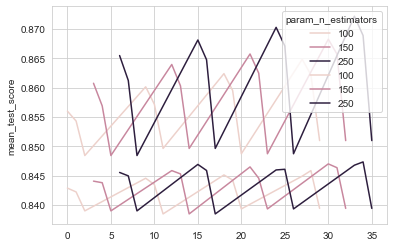

In [535]:
sns.lineplot(data=results, x=list(results.index), y="mean_test_score", hue='param_n_estimators')
sns.lineplot(data=results, x=list(results.index), y="mean_train_score", hue='param_n_estimators')


In [536]:
print(classification_report(y_test, val_preds))

              precision    recall  f1-score   support

           0       0.65      0.79      0.71      5678
           1       0.79      0.72      0.75      8098
           2       0.45      0.18      0.25      1074

    accuracy                           0.71     14850
   macro avg       0.63      0.56      0.57     14850
weighted avg       0.71      0.71      0.70     14850



## IN PROGRESS- Predict Test Set Values

In [39]:
# Load and split preprocessed data into X and y
with open('X_submission.pickle', 'rb') as f:
    X = pickle.load(f)

In [40]:
# Replace all NaN elements with 0s.
X.fillna(0, inplace=True)

In [41]:
X[['region_code', 'district_code']] = X[['region_code', 'district_code']].astype(str)
X.drop(columns=['date_recorded'], inplace=True)

In [42]:
X_obj=X.select_dtypes('object')
X=X.select_dtypes(exclude='object')

In [43]:
X.head()

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
0,0.0,1996,35.290799,-4.059696,0,321,2012
1,0.0,1569,36.656709,-3.309214,0,300,2000
2,0.0,1567,34.767863,-5.004344,0,500,2010
3,0.0,267,38.058046,-9.418672,0,250,1987
4,500.0,1260,35.006123,-10.950412,0,60,2000


In [44]:
# Scale data
scaler = StandardScaler()

scaled_features = scaler.fit_transform(X)

# Transform test sets
scaled_X = pd.DataFrame(scaled_features, index=X.index, columns=X.columns)

In [45]:
scaled_X

,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
0,-0.128571,1.939784,0.073435,0.612347,-0.050821,0.291567,0.756161
1,-0.128571,1.322052,0.599971,0.879566,-0.050821,0.246837,0.743598
2,-0.128571,1.319159,-0.128149,0.275994,-0.050821,0.672837,0.754067
3,-0.128571,-0.561525,1.140164,-1.295783,-0.050821,0.140337,0.729989
4,0.070562,0.875028,-0.036303,-1.841177,-0.050821,-0.264363,0.743598
...,...,...,...,...,...,...,...
14845,-0.128571,-0.898602,1.446478,-0.286050,-0.050821,-0.349563,0.731036
14846,0.269695,-0.947789,0.906402,0.152766,-0.050821,5.912637,0.737317
14847,-0.128571,1.187511,-0.138965,0.425098,-0.050821,0.033837,0.754067
14848,-0.128571,0.495998,0.128147,-1.710768,-0.050821,-0.072663,0.753020


In [46]:
X = pd.concat([X_obj, scaled_X], axis=1)

In [47]:
X.head()

,funder,installer,wpt_name,basin,subvillage,region,region_code,district_code,lga,ward,...,source_class,waterpoint_type,waterpoint_type_group,amount_tsh,gps_height,longitude,latitude,num_private,population,construction_year
0,Dmdd,DMDD,Dinamu Secondary School,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,...,surface,other,other,-0.128571,1.939784,0.073435,0.612347,-0.050821,0.291567,0.756161
1,Government Of Tanzania,DWE,Kimnyak,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,...,groundwater,communal standpipe,communal standpipe,-0.128571,1.322052,0.599971,0.879566,-0.050821,0.246837,0.743598
2,0,0,Puma Secondary,Internal,Msatu,Singida,13,2,Singida Rural,Puma,...,surface,other,other,-0.128571,1.319159,-0.128149,0.275994,-0.050821,0.672837,0.754067
3,Finn Water,FINN WATER,Kwa Mzee Pange,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,...,groundwater,other,other,-0.128571,-0.561525,1.140164,-1.295783,-0.050821,0.140337,0.729989
4,Bruder,BRUDER,Kwa Mzee Turuka,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,...,groundwater,communal standpipe,communal standpipe,0.070562,0.875028,-0.036303,-1.841177,-0.050821,-0.264363,0.743598


In [35]:
y_test = grid_clf.predict(X) # test with encoded unseen data 